In [2]:
import pandas as pd
import os
import preprocessor as p
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=30)

from src.data.utils import find_emojis, save_to_csv

INFO: Pandarallel will run on 30 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
path = '/scratch/czestoch/twitter-api-emojis-parquets'
dfs = []
for filename in os.listdir(path):
    dfs.append(pd.read_parquet(os.path.join(path, filename)))
df = pd.concat(dfs)
len(df)

1472466

In [4]:
df.head()

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text
0,78,1187462340444164096,2019-10-24 20:14:18+00:00,en,1183091385043505152,124,2,92871,⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ 💹💹💹 ⬛⬛⬛⬛⬛ the hat of...
1,185,1187460864938397696,2019-10-24 20:08:26+00:00,en,993590061894529024,2301,7,92777,Score 410 ▫️▫️▫️▫️▫️▫️▫️▫️▫️ ▫️⬛▫️⬛▫️⬛▫️🕛▫️ ▫️...
2,80,1187459802986762241,2019-10-24 20:04:13+00:00,en,1183091385043505152,124,2,92871,⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ 👩🏼‍💻👩🏼‍💻👩🏼‍💻 ⬛⬛⬛⬛⬛ t...
3,64,1187457385239056387,2019-10-24 19:54:37+00:00,en,1183091385043505152,124,2,92871,⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ ⬛⬛⬛ ⠀ 📙📙📙 ⬛⬛⬛⬛⬛ the hat of...
4,223,1187457127922700291,2019-10-24 19:53:35+00:00,en,2350442972,52173,36611,167854,Allow Me To Blow Your Account ⚛⬛⚛⬛⚛ ⚛100K ◼ ⬛⚛...


In [5]:
df[df.isnull().any(axis=1)]

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text


In [6]:
len(df[df.duplicated()])

192542

In [7]:
df = df.drop_duplicates()

In [8]:
len(df[df.duplicated("text")])

171251

In [9]:
df = df.drop_duplicates("text")

In [10]:
f"{len(df):,}"

'1,108,673'

In [11]:
df.describe()

,n_chars,user_n_followers,user_n_following,user_n_tweets
count,1.108673e+06,1.108673e+06,1.108673e+06,1.108673e+06
mean,1.336801e+02,1.816301e+04,1.812324e+03,3.981207e+04
std,9.211657e+01,3.998634e+05,9.286202e+03,1.073475e+05
min,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.800000e+01,1.670000e+02,1.700000e+02,2.574000e+03
50%,1.100000e+02,6.530000e+02,5.100000e+02,1.070300e+04
75%,2.020000e+02,2.583000e+03,1.397000e+03,3.606400e+04
max,1.021000e+03,1.088266e+08,4.205037e+06,6.931029e+06


In [12]:
df[df.n_chars == 4].text

415     Yuck
677     Awit
753     Shit
1058    NEAL
2185    Game
3328    fome
Name: text, dtype: object

In [13]:
df['emojis'] = df.text.parallel_apply(find_emojis)

In [14]:
df['n_emojis'] = df.emojis.parallel_apply(len)

In [19]:
df = df[df.n_emojis >= 1]

from collections import Counter
flatten = lambda t: [item for sublist in t for item in sublist]
emoji_counts = Counter(flatten(df['emojis'].apply(set).tolist()))
df2 = {"emoji": list(emoji_counts.keys()), "count": list(emoji_counts.values())}
df2 = pd.DataFrame.from_records(df2)

context_free_emojis = pd.read_csv("/scratch/czestoch/emoji-measures/ambiguity_variation.csv.gz").emoji
context_free_emojis

df2 = df2[df2.emoji.isin(context_free_emojis.tolist())]

save_to_csv(df2, "/scratch/czestoch/emoji-measures/twitter-api-context-free-emoji-counts.csv")

In [15]:
f"{len(df[df.n_emojis == 1]):,}"

'290,817'

In [16]:
#Choose only tweets with one emoji
df1 = df[df.n_emojis == 1]

In [15]:
# p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG)
# p.clean(df.iloc[0].text)

'Lmaoooo hunnit this shit leaving me so confused🥴'

In [16]:
# df["cleaned_text"] = df.text.parallel_apply(lambda x: p.clean(x))

In [17]:
# df = df.drop("n_emojis", axis=1)

In [17]:
df1.emojis = df1.emojis.parallel_apply(lambda x: x[0])

/home/czestoch/.local/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
em = df1[df1['emojis'] == '🈹']
print(len(em))
em.user_id.nunique()

121


32

In [24]:
em[['user_id', 'text']]

,user_id,text
1,4613953846,Sat Sep 14 2019 02:41:13 GMT+0000 (Coordinated...
2,4613953846,Sat Sep 14 2019 02:27:12 GMT+0000 (Coordinated...
5,774694926135222272,I 🈹 Virginia Beach
10,837840863535456256,"defaced 🈹 negativity ,"
12,4613953846,Thu Sep 12 2019 10:51:32 GMT+0000 (Coordinated...
...,...,...
268,4613953846,Mon Sep 16 2019 19:25:49 GMT+0000 (Coordinated...
269,4613953846,Mon Sep 16 2019 11:35:22 GMT+0000 (Coordinated...
270,4613953846,Mon Sep 16 2019 09:45:15 GMT+0000 (Coordinated...
273,4613953846,Sun Sep 15 2019 04:11:35 GMT+0000 (Coordinated...


In [27]:
em[em.user_id == '4613953846']

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text,emojis,n_emojis
1,65,1172701808654979072,2019-09-14 02:41:13+00:00,en,4613953846,5,0,1048378,Sat Sep 14 2019 02:41:13 GMT+0000 (Coordinated...,🈹,1
2,65,1172698281870331904,2019-09-14 02:27:12+00:00,en,4613953846,5,0,1048378,Sat Sep 14 2019 02:27:12 GMT+0000 (Coordinated...,🈹,1
12,65,1172100424926670848,2019-09-12 10:51:32+00:00,en,4613953846,5,0,1048378,Thu Sep 12 2019 10:51:32 GMT+0000 (Coordinated...,🈹,1
16,65,1171623518330675200,2019-09-11 03:16:29+00:00,en,4613953846,5,0,1048378,Wed Sep 11 2019 03:16:29 GMT+0000 (Coordinated...,🈹,1
18,65,1171539381141639169,2019-09-10 21:42:09+00:00,en,4613953846,5,0,1048378,Tue Sep 10 2019 21:42:09 GMT+0000 (Coordinated...,🈹,1
...,...,...,...,...,...,...,...,...,...,...,...
257,65,1174272177056768002,2019-09-18 10:41:18+00:00,en,4613953846,5,0,1048378,Wed Sep 18 2019 10:41:18 GMT+0000 (Coordinated...,🈹,1
268,65,1173679399285219328,2019-09-16 19:25:49+00:00,en,4613953846,5,0,1048378,Mon Sep 16 2019 19:25:49 GMT+0000 (Coordinated...,🈹,1
269,65,1173561005932261377,2019-09-16 11:35:22+00:00,en,4613953846,5,0,1048378,Mon Sep 16 2019 11:35:22 GMT+0000 (Coordinated...,🈹,1
270,65,1173533297349144583,2019-09-16 09:45:15+00:00,en,4613953846,5,0,1048378,Mon Sep 16 2019 09:45:15 GMT+0000 (Coordinated...,🈹,1


In [18]:
tweets_per_emoji = df1.groupby("emojis").text.count()

In [19]:
df1.emojis.nunique()

867

In [20]:
tweets_per_emoji.describe()

count     867.000000
mean      335.429066
std       429.617917
min         1.000000
25%         4.000000
50%       184.000000
75%       537.500000
max      4173.000000
Name: text, dtype: float64

In [21]:
tweets_per_emoji[tweets_per_emoji == tweets_per_emoji.max()]

emojis
☹️    4173
Name: text, dtype: int64

In [22]:
tweets_per_emoji[tweets_per_emoji == tweets_per_emoji.min()]

emojis
1️⃣    1
©      1
®      1
▶      1
☁      1
      ..
🦒      1
🧐      1
🧚      1
🧠      1
🧢      1
Name: text, Length: 124, dtype: int64

In [23]:
# Choose tweets with emojis that appeared in at least 30 different tweets
# df = df[df.emojis.isin(tweets_per_emoji[tweets_per_emoji >= 30].index)]

In [24]:
#f"{len(df):,}"

In [25]:
df.emojis.nunique()

2581

In [26]:
# dir_path = "/scratch/czestoch/emoji-measures/"
# context_free_emojis = pd.read_csv(os.path.join(dir_path, "ambiguity_variation.csv.gz"))["emoji"]

In [27]:
# df = df[df.emojis.isin(context_free_emojis)]
# print(f"{len(df):,}")
# df.emojis.nunique()

978,017


1207

In [28]:
# df.to_parquet('/scratch/czestoch/cleaned_english_emoji_tweets_2019_09.parquet.gzip', compression='gzip')

In [29]:
########################################################################################

In [30]:
# print("Loading data...")
# path = "/scratch/czestoch/cleaned_english_emoji_tweets_2019_09.parquet.gzip"
# tweets = pd.read_parquet(path)[["cleaned_text", "emojis"]]
# tweets = tweets.rename({"cleaned_text": "tweet"}, axis=1)
# tweets.head()

Loading data...


,tweet,emojis
0,Lmaoooo hunnit this shit leaving me so confused🥴,🥴
1,Got something going through my brain that I ca...,🤯
3,stan marty the coke snorting king 🤩,🤩
8,unfollow 🤭,🤭
10,Please do if it’s not too much trouble!! 😊,😊


In [23]:
df1.head()

,n_chars,tweet_id,created_at,lang,user_id,user_n_followers,user_n_following,user_n_tweets,text,emojis,n_emojis
26,213,1187428541706584064,2019-10-24 18:00:00+00:00,en,22045925,3208,391,9679,"The Release Raffle for the Dunk Low ""Night of ...",⬛,1
64,46,1187384988020424706,2019-10-24 15:06:56+00:00,en,1062251903864791040,571,2,24726,Success by Yeezus710 ⬛,⬛,1
67,112,1187383316447518720,2019-10-24 15:00:17+00:00,en,1894112550,766173,377,173568,"Chances at both ends, but it's all ⬛ in Kochi!",⬛,1
81,132,1187005758627549189,2019-10-23 14:00:01+00:00,en,22045925,3208,391,9679,As tough as it is versatile: the Slip On Pro ⬛,⬛,1
205,147,1186280983072346117,2019-10-21 14:00:01+00:00,en,22045925,3208,391,9679,Graphics that are never boring: the latest pro...,⬛,1


In [24]:
tweets = df1[['text', 'emojis']]
tweets = tweets.rename({"text": "tweet"}, axis=1)

In [25]:
df1 = tweets.groupby("emojis").tweet.count()
df1 = df1.to_frame().reset_index()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : True})

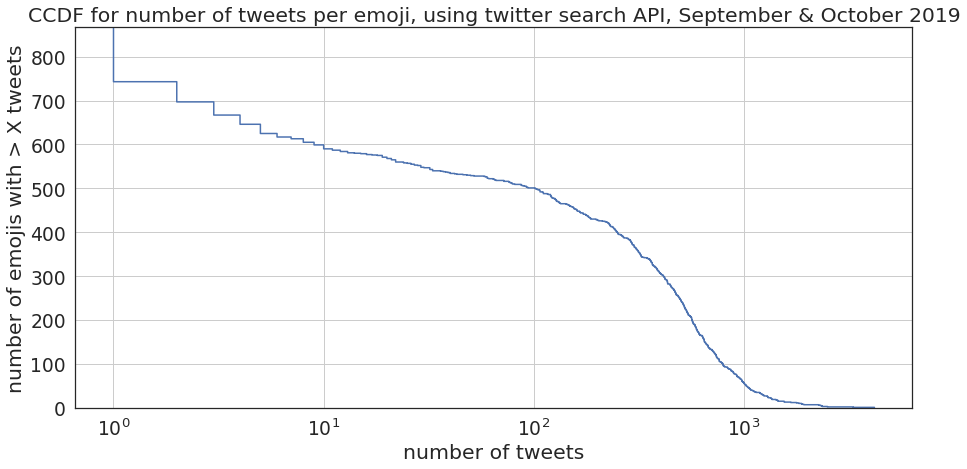

In [27]:
fig, ax = plt.subplots()
ax = sns.ecdfplot(data=df1, x="tweet", stat='count', complementary=True, ax=ax)
ax.set_title("CCDF for number of tweets per emoji, using twitter search API, September & October 2019")
ax.set_xscale("log")
ax.set_xlabel("number of tweets")
ax.set_ylabel("number of emojis with > X tweets");

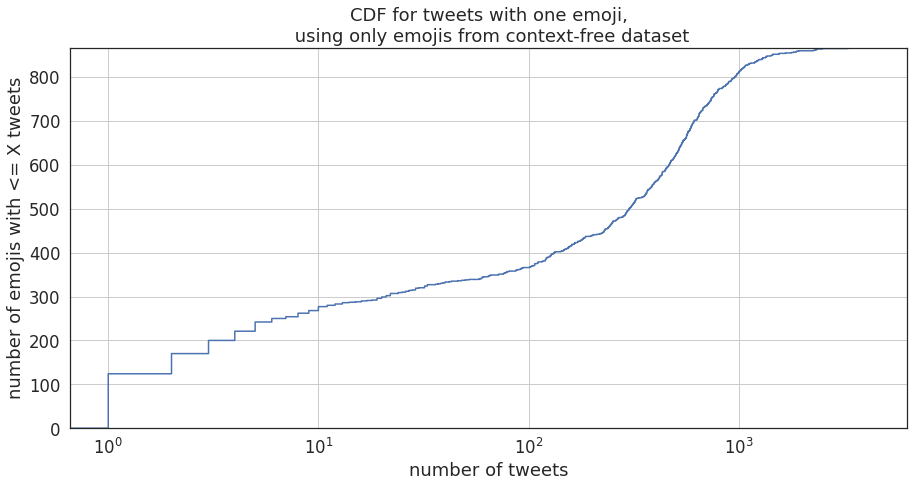

In [63]:
fig, ax = plt.subplots()
ax = sns.ecdfplot(data=df1, x="tweet", stat='count', ax=ax)
ax.set_title("CDF for tweets with one emoji,\n using only emojis from context-free dataset")
ax.set_xscale("log")
ax.set_xlabel("number of tweets")
ax.set_ylabel("number of emojis with <= X tweets");

In [64]:
len(df1[df1.tweet >= 100])

501

In [65]:
len(df1[df1.tweet >= 30])

548

In [66]:
df1[df1.tweet >= 100].emojis.values

array(['©️', '®️', '‼️', '™️', 'ℹ️', '↔️', '↕️', '↖️', '↗️', '↘️', '↙️',
       '↩️', '↪️', '⌚', '⌛', '⏩', '⏫', '⏬', '⏭️', '⏯️', '⏰', '⏱️', '⏲️',
       '⏳', '⏸️', '⏹️', '⏺️', 'Ⓜ️', '▶️', '◽', '☀️', '☁️', '☂️', '☃️',
       '☄️', '☎️', '☑️', '☔', '☕', '☘️', '☝️', '☠️', '☢️', '☣️', '☦️',
       '☪️', '☮️', '☯️', '☸️', '☹️', '☺️', '♈', '♉', '♊', '♋', '♌', '♍',
       '♎', '♏', '♐', '♑', '♒', '♓', '♟️', '♠️', '♣️', '♥️', '♦️', '♨️',
       '♻️', '♾️', '♿', '⚒️', '⚓', '⚔️', '⚖️', '⚗️', '⚙️', '⚛️', '⚜️',
       '⚠️', '⚡', '⚰️', '⚱️', '⚽', '⚾', '⛄', '⛅', '⛈️', '⛎', '⛏️', '⛑️',
       '⛓️', '⛔', '⛩️', '⛪', '⛰️', '⛱️', '⛲', '⛳', '⛴️', '⛵', '⛷️', '⛸️',
       '⛹️', '⛹️\u200d♀️', '⛹️\u200d♂️', '⛺', '⛽', '✂️', '✅', '✈️', '✉️',
       '✊', '✊🏻', '✊🏼', '✊🏽', '✊🏾', '✋', '✋🏻', '✋🏼', '✌️', '✍️', '✏️',
       '✒️', '✔️', '✖️', '✝️', '✡️', '✨', '✳️', '✴️', '❄️', '❇️', '❌',
       '❎', '❓', '❔', '❕', '❗', '❣️', '❤️', '➕', '➖', '➗', '➡️', '➰', '➿',
       '⤴️', '⤵️', '⬅️', '⬆️', '⬇️', '⭐', '⭕', '〰️', '〽️'

In [42]:
df1[df1.tweet >= 30].emojis.values

array(['©️', '‼️', '⁉️', '™️', '⌚', '⏰', '⏳', '▶️', '☀️', '☁️', '☄️',
       '☎️', '☑️', '☔', '☕', '☘️', '☝️', '☠️', '☢️', '☮️', '☹️', '☺️',
       '♈', '♋', '♍', '♎', '♠️', '♥️', '♻️', '⚓', '⚔️', '⚖️', '⚜️', '⚠️',
       '⚡', '⚫', '⚰️', '⚽', '⚾', '⛅', '⛳', '⛽', '✂️', '✅', '✈️', '✊', '✋',
       '✌️', '✍️', '✏️', '✔️', '✝️', '✨', '❄️', '❌', '❓', '❕', '❗', '❣️',
       '❤️', '➡️', '⤵️', '⬆️', '⬇️', '⭐', '⭕', '🃏', '🅱️', '🅿️', '🆗', '🆘',
       '🌀', '🌃', '🌄', '🌅', '🌈', '🌊', '🌋', '🌌', '🌍', '🌎', '🌏', '🌐', '🌕',
       '🌙', '🌚', '🌛', '🌝', '🌞', '🌟', '🌠', '🌮', '🌯', '🌱', '🌲', '🌳', '🌴',
       '🌵', '🌷', '🌸', '🌹', '🌺', '🌻', '🌼', '🌽', '🌾', '🌿', '🍀', '🍁', '🍂',
       '🍃', '🍄', '🍅', '🍆', '🍇', '🍉', '🍊', '🍋', '🍌', '🍍', '🍎', '🍏', '🍑',
       '🍒', '🍓', '🍔', '🍕', '🍗', '🍜', '🍝', '🍞', '🍟', '🍣', '🍦', '🍩', '🍪',
       '🍫', '🍬', '🍭', '🍯', '🍰', '🍳', '🍴', '🍵', '🍷', '🍸', '🍹', '🍺', '🍻',
       '🍼', '🍾', '🍿', '🎀', '🎁', '🎂', '🎃', '🎄', '🎈', '🎉', '🎊', '🎒', '🎓',
       '🎣', '🎤', '🎥', '🎧', '🎨', '🎩', '🎪', '🎫', '🎬', '🎭', '

In [68]:
tweets = tweets[tweets.emojis.isin(df1[df1.tweet >= 100].emojis.values)]

In [69]:
equalized = tweets.groupby("emojis").sample(n=100, replace=False).reset_index()
equalized.head()

,index,tweet,emojis
0,659,เบื้องหลังการถ่ายภาพนิตยสาร OK R1SE 11 child f...,©️
1,449,Do what you have to do until you can do what y...,©️
2,505,And we both go to sleep in WELÇOME©️,©️
3,66,©️ Ethan Dow.,©️
4,91,หนุ่ม R1SE ไปออกรายการช่อง BTV คะ met Temple o...,©️


In [70]:
equalized.emojis.nunique()

501

In [71]:
save_to_csv(equalized[["tweet", "emojis"]], "/scratch/czestoch/cleaned_equalized_0910-2019-api_tweets.csv")